# Описание проекта
В этом проекте нам предстоит разработать модель для предсказания риска сердечного приступа, используя данные пациентов, такие как возраст, привычки, состояние здоровья и результаты анализа крови, а также сделать для нее приложение на FastAPI или аналогичном фреймворке для получения предсказаний по пользовательскому запросу.

## 1. Загрузка данных

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Выполним необходимые импорты</font>

In [116]:
!pip install -r requirements.txt

In [117]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import phik
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report



In [118]:
import catboost
print(catboost.__version__)

1.2.8


In [119]:
RANDOM_STATE = 42

In [120]:
DEFAULT_PALETTE = [
    "#FF9999",  # розовый
    "#66B3FF",  # голубой
    "#99FF99",  # салатовый
    "#FFCC99",  # персиковый
    "#ff8c69",  # лососевый
    "#acb78e",  # болотный
    # можно добавить ещё цвета при необходимости
]

In [121]:
def missing_report(df):
    """
    Генерирует отчёт по пропущенным значениям в DataFrame.

    Функция вычисляет для каждого столбца:
      - общее количество пропущенных значений,
      - долю пропущенных значений от общего числа строк (в процентах, с точностью до 2 знаков).

    Результатом является новый DataFrame с двумя колонками:
      - `missing_values`: количество пропусков в столбце,
      - `% of total`: процент пропусков от общего числа строк.

    Столбцы в отчёте отсортированы по убыванию количества пропущенных значений.

    Args:
        df (pandas.DataFrame): Исходный DataFrame для анализа пропусков.

    Returns:
        pandas.DataFrame: Отчёт с количеством и процентом пропусков для каждого столбца.
    """
    cnt = df.isna().sum()
    pct = (cnt / len(df) * 100).round(2)
    report = (
        pd.concat([cnt, pct], axis=1, keys=['missing_values', '% of total'])
          .sort_values('missing_values', ascending=False)
    )
    return report

In [122]:
def duplicate_report(df):
    """
    Генерирует отчёт по дублированным строкам в DataFrame.

    Функция вычисляет общее число строк-дубликатов в переданном DataFrame
    и рассчитывает их долю от общего количества строк в процентах (с точностью до 2 знаков).

    Args:
        df (pandas.DataFrame): Исходный DataFrame для анализа дубликатов.

    Returns:
        pandas.DataFrame: Однострочный отчёт с двумя колонками:
            - `duplicate_rows`: количество повторяющихся строк,
            - `% of total`: процент дубликатов от общего числа строк.
    """
    total = len(df)
    dup_cnt = df.duplicated().sum()
    dup_pct = (dup_cnt / total * 100).round(2)
    report = pd.DataFrame({
        'duplicate_rows': [dup_cnt],
        '% of total':    [dup_pct]
    }, index=[''])
    return report

In [123]:
def normalize_text(df, cols=None):
    """
    Нормализует текстовые столбцы в DataFrame.

    Функция создаёт копию переданного DataFrame и приводит все значения в указанных
    текстовых столбцах к одному виду: преобразует в нижний регистр, убирает лишние
    пробелы в начале и конце строк, а также заменяет последовательности из
    нескольких пробельных символов одним пробелом.

    Args:
        df (pandas.DataFrame): Исходный DataFrame, содержищий столбцы для нормализации.
        cols (list of str or None, optional): Список имён столбцов, над которыми нужно
            выполнить нормализацию. Если None, то автоматически выбираются все
            столбцы типов object, string или category. По умолчанию None.

    Returns:
        pandas.DataFrame: Копия исходного DataFrame, в которой указанные столбцы
            содержат нормализованные текстовые значения. Пропущенные значения не трогаются.
    """
    df_norm = df.copy()
    if cols is None:
        cols = df_norm.select_dtypes(include=['object', 'string', 'category']).columns

    for col in cols:
        s = df_norm[col]
        mask = s.notna()
        df_norm.loc[mask, col] = (
            s[mask]
            .astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r'\s+', ' ', regex=True)
        )
    return df_norm

In [124]:
def text_dup_report(df):
    """
    Выводит отчёт о повторяющихся и уникальных текстовых значениях в DataFrame.

    Для каждого текстового столбца (типов object, string или category):
      - подсчитывается число уникальных значений (без учёта NaN);
      - выводится имя столбца и количество уникальных значений;
      - если число уникальных значений меньше 10, дополнительно выводятся частоты
        всех значений (включая NaN).

    Args:
        df (pandas.DataFrame): Исходный DataFrame для анализа текстовых столбцов.

    Returns:
        None: Функция выводит результаты в консоль и не возвращает DataFrame.
    """
    text_cols = df.select_dtypes(include=['object', 'string', 'category']).columns

    for col in text_cols:
        n_unique = df[col].nunique(dropna=True)

        print(f"--- Column: \033[0;34m{col}\033[0m ---")
        print(f"Unique values: {n_unique}")

        if n_unique < 10:
            print("Value counts:")
            print(df[col].value_counts(dropna=False))

        print()

In [125]:
def plot_hist_and_box(data,
                      column='id',
                      bins=40,
                      figsize=(16,8),
                      hist_title='Гистограмма',
                      box_title='Диаграмма размаха',
                      axis_label='Заголовок по оси X',
                      suptitle='Общий заголовок',
                     ):
    """
    Строит рядом гистограмму и диаграмму размаха для одного столбца DataFrame.

    Функция создаёт две панели в одной фигуре:
      1. Гистограмма распределения значений с оценкой плотности (kde) и вертикальной
         линией, обозначающей медиану.
      2. Диаграмма размаха (boxplot), показывающая разброс и выбросы.

    Args:
        data (pandas.DataFrame): Исходный DataFrame с данными.
        column (str): Имя числового столбца, по которому строятся графики.
            По умолчанию 'active_6m'.
        bins (int): Число корзин (bins) для гистограммы. По умолчанию 40.
        figsize (tuple of int): Размер фигуры в дюймах (width, height).
            По умолчанию (16, 8).
        hist_title (str): Заголовок над гистограммой. По умолчанию 'Гистограмма'.
        box_title (str): Заголовок над диаграммой размаха. По умолчанию 'Диаграмма размаха'.
        axis_label (str): Подпись по оси X для гистограммы. По умолчанию 'Заголовок по оси X'.
        suptitle (str): Общий заголовок всей фигуры. По умолчанию 'Общий заголовок'.

    Returns:
        None: Функция отображает графики и не возвращает значение.
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Гистограмма с линией медианы
    sns.histplot(data=data, x=column, ax=axs[0], bins=bins, kde=True)
    median_val = data[column].median()
    axs[0].axvline(median_val, linestyle='--', label='Медиана')
    axs[0].legend()
    axs[0].set_xlabel(axis_label)
    axs[0].set_ylabel('Количество пациентов')
    axs[0].set_title(hist_title)

    # Диаграмма размаха
    sns.boxplot(data=data, x=column, ax=axs[1])
    axs[1].set_title(box_title)

    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

In [126]:
def plot_three_pie_charts(data, columns, titles, palette=DEFAULT_PALETTE, figsize=(15, 8)):
    # if palette is None:
    #     palette = [
    #         "#FF9999",  # розовый
    #         "#66B3FF",  # голубой
    #         "#99FF99",  # салатовый
    #         "#FFCC99",  # персиковый
    #         # можно добавить ещё цвета при необходимости
    #     ]

    if len(columns) != 3 or len(titles) != 3:
        raise ValueError("Пожалуйста, передайте ровно три столбца и три заголовка.")

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    for ax, col, title in zip(axs, columns, titles):
        data[col].value_counts().plot(
            kind='pie',
            autopct='%1.0f%%',
            title=title,
            colors=palette,
            ax=ax
        )
        ax.set_xlabel('')
        ax.set_ylabel('')

    plt.tight_layout()
    plt.show()

In [127]:
# Создаем функцию для извлечения F1-score класса 1 из classification report
def get_class_1_f1(report_str):
    for line in report_str.split('\n'):
        if line.strip().startswith('1.0'):
            return float(line.strip().split()[3])
    return 0.0

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Загрузим данные из csv-файлов в датафреймы c помощью библиотеки pandas</font>

In [128]:
try:
    df_test = pd.read_csv('heart_project/data/heart_test.csv')
except FileNotFoundError:
    df_test = pd.read_csv('data/heart_test.csv')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

In [129]:
try:
    df_train = pd.read_csv('heart_project/data/heart_train.csv')
except FileNotFoundError:
    df_train = pd.read_csv('data/heart_train.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [130]:
df_train.head(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,...,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,...,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,...,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,...,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,...,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


In [131]:
df_test.head(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
5,5,0.561798,0.792857,0.026581,1.0,1.0,1.0,1.0,0.0,0.774470,...,0.362338,1.0,0.666667,0.227018,0.048229,0.036512,Male,0.161290,0.593023,1076
6,6,0.674157,0.853571,0.019248,1.0,1.0,1.0,0.0,1.0,0.149123,...,0.211688,3.0,0.000000,0.227018,0.048229,0.036512,Male,0.535484,0.546512,5020
7,7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,...,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,Male,0.496774,0.662791,4267
8,8,0.449438,0.328571,0.075160,1.0,0.0,1.0,0.0,0.0,0.487405,...,0.819481,2.0,0.166667,0.227018,0.048229,0.036512,Male,0.677419,0.430233,4003
9,9,0.617978,0.728571,0.032081,0.0,1.0,1.0,0.0,0.0,0.211485,...,0.196104,0.0,1.000000,0.227018,0.048229,0.036512,Male,0.722581,0.255814,2519


In [132]:
df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_train.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [133]:
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> мы сделали необходимые импорты, создали датафреймы, изучили данные. Удалили столбец "Unnamed: 0"</font>

## 2. Предобработка данных

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Посмотрим пропуски в данных</font>

In [134]:
missing_report(df_train)

,missing_values,% of total
Physical Activity Days Per Week,243,2.8
Diabetes,243,2.8
Family History,243,2.8
Smoking,243,2.8
Obesity,243,2.8
Alcohol Consumption,243,2.8
Previous Heart Problems,243,2.8
Medication Use,243,2.8
Stress Level,243,2.8
Troponin,0,0.0


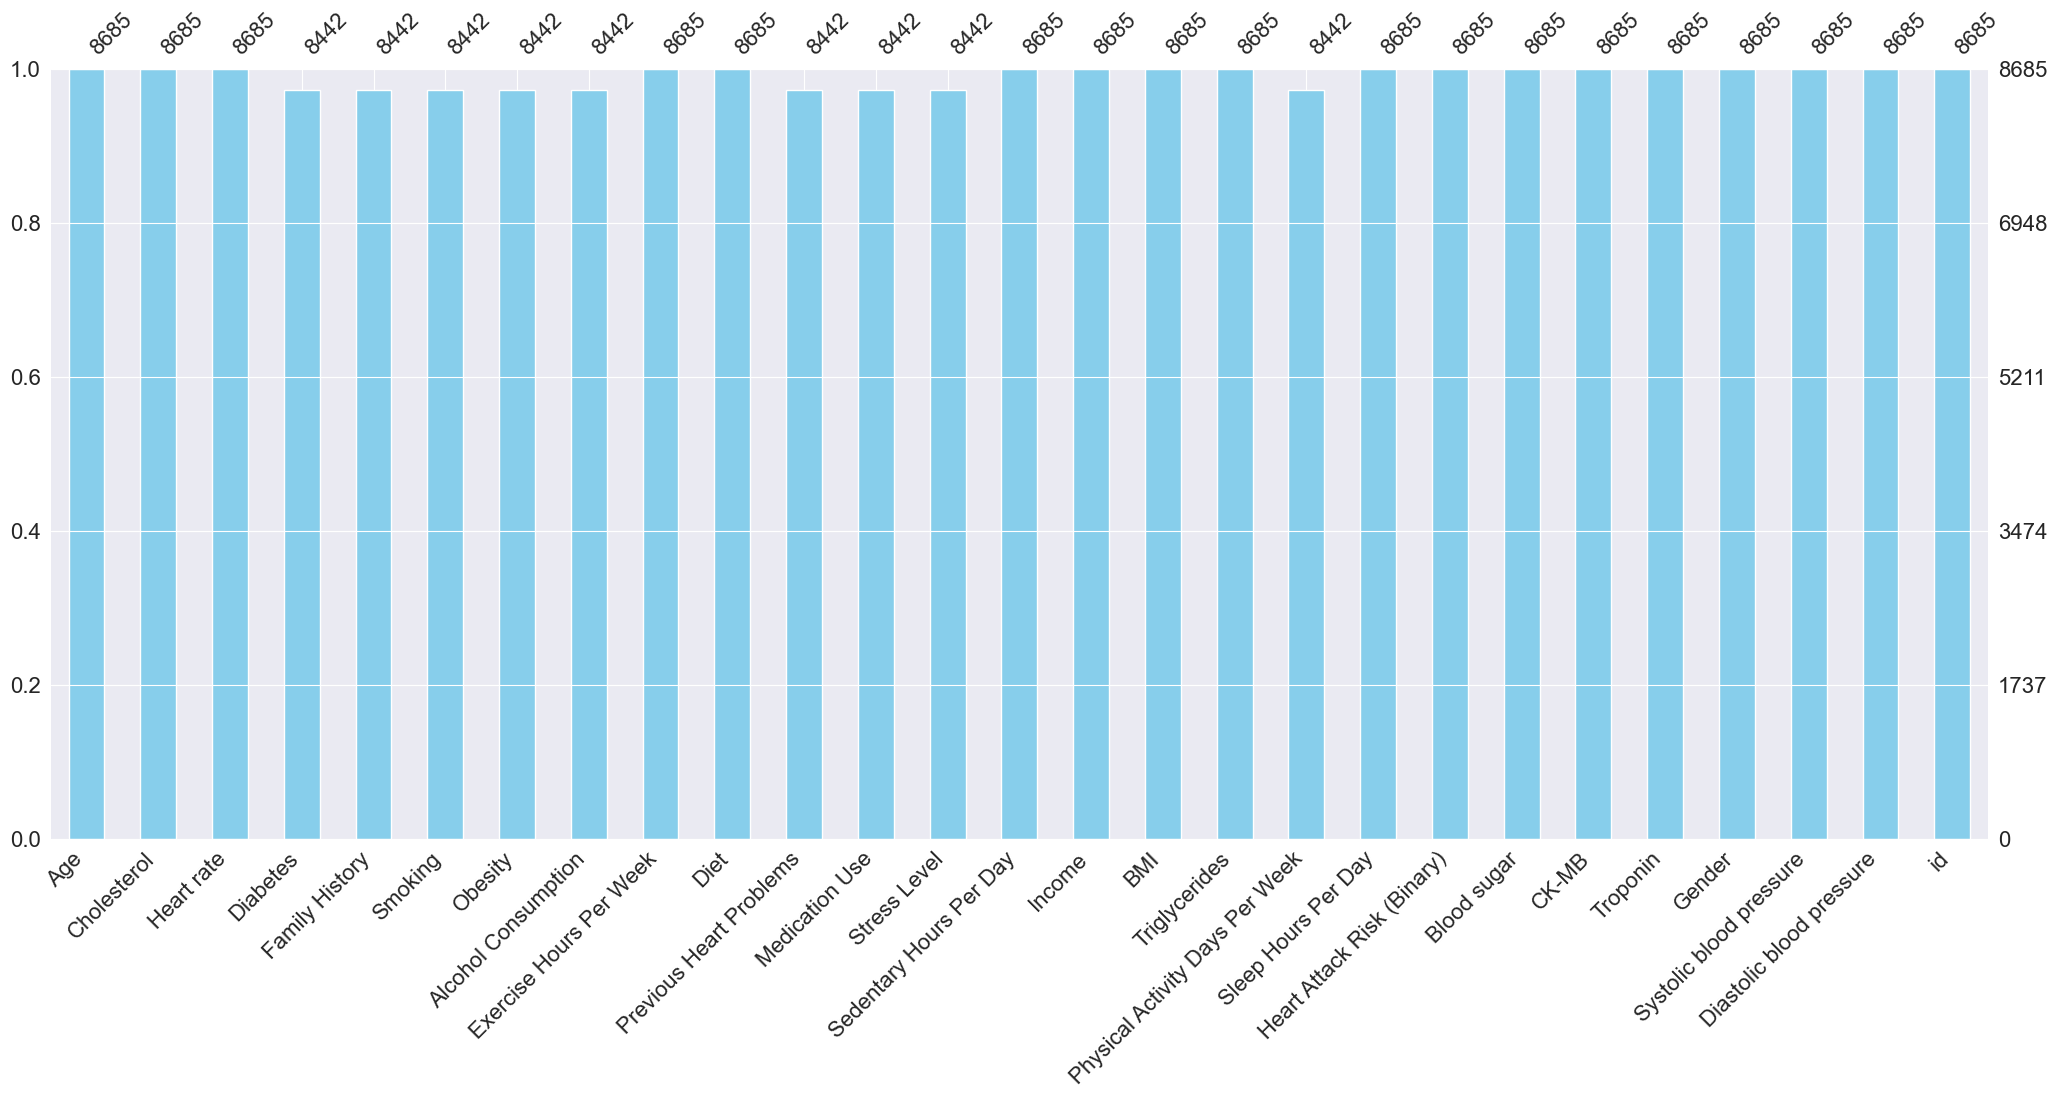

In [135]:
msno.bar(df_train, color='skyblue');

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Посмотрим явные дубликаты</font>

In [136]:
duplicate_report(df_train)

,duplicate_rows,% of total
,0,0.0


<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Посмотрим не явные дубликаты в текстовых столбцах</font>

In [137]:
normalize_text(df_train)

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,male,0.619355,0.441860,4047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,2,...,0.0,0.166667,0.0,0.136364,0.006771,0.088261,male,0.632258,0.511628,5734
8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,2,...,6.0,0.833333,0.0,0.195652,0.008339,0.000777,male,0.561290,0.511628,5191
8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,2,...,1.0,0.833333,0.0,0.227018,0.048229,0.036512,male,0.374194,0.558140,5390
8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,2,...,4.0,0.500000,0.0,0.227018,0.048229,0.036512,male,0.477419,0.744186,860


In [138]:
text_dup_report(df_train)

--- Column: Gender ---
Unique values: 4
Value counts:
Gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64



In [139]:
df_train['Gender'] = df_train['Gender'].replace({'Male': '1.0', 'Female': '0.0'})

In [140]:
df_test['Gender'] = df_test['Gender'].replace({'Male': '1.0', 'Female': '0.0'})

In [141]:
text_dup_report(df_train)

--- Column: Gender ---
Unique values: 2
Value counts:
Gender
1.0    6038
0.0    2647
Name: count, dtype: int64



In [142]:
df_train['Gender'] = df_train['Gender'].astype('float64').astype('int64')

In [143]:
df_test['Gender'] = df_test['Gender'].astype('float64').astype('int64')

<div style="background-color:aquamarine; color:#black; text-align:left; padding:2%">
<font size="4", color= "black"><b>Результат:</b> есть незначительные пропуски в данных, явные и не явные дубликаты обработаны</font>

## 3. Исследовательский анализ данных

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Проведем исследовательский анализ данных</font>

In [144]:
df_train.describe()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,...,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,...,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.695222,0.450295,0.497634,4831.210823
std,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,...,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.460340,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,...,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.000000,0.303226,0.348837,2425.000000
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,...,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,1.000000,0.445161,0.500000,4837.000000
75%,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,...,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,1.000000,0.600000,0.651163,7242.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,...,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


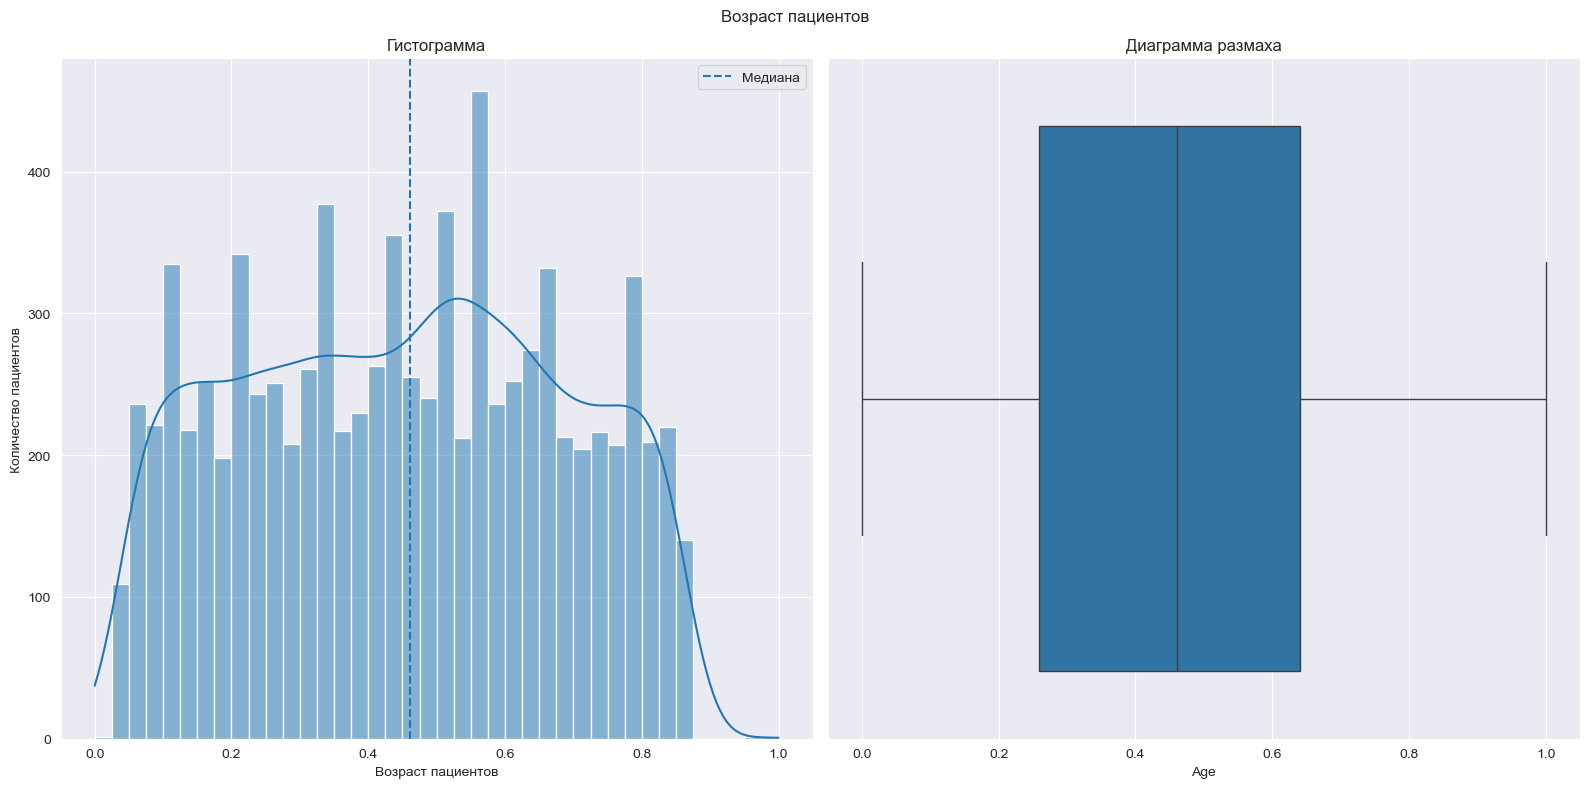

In [145]:
plot_hist_and_box(df_train,
                  column='Age',
                  axis_label='Возраст пациентов',
                  suptitle='Возраст пациентов'
                 )

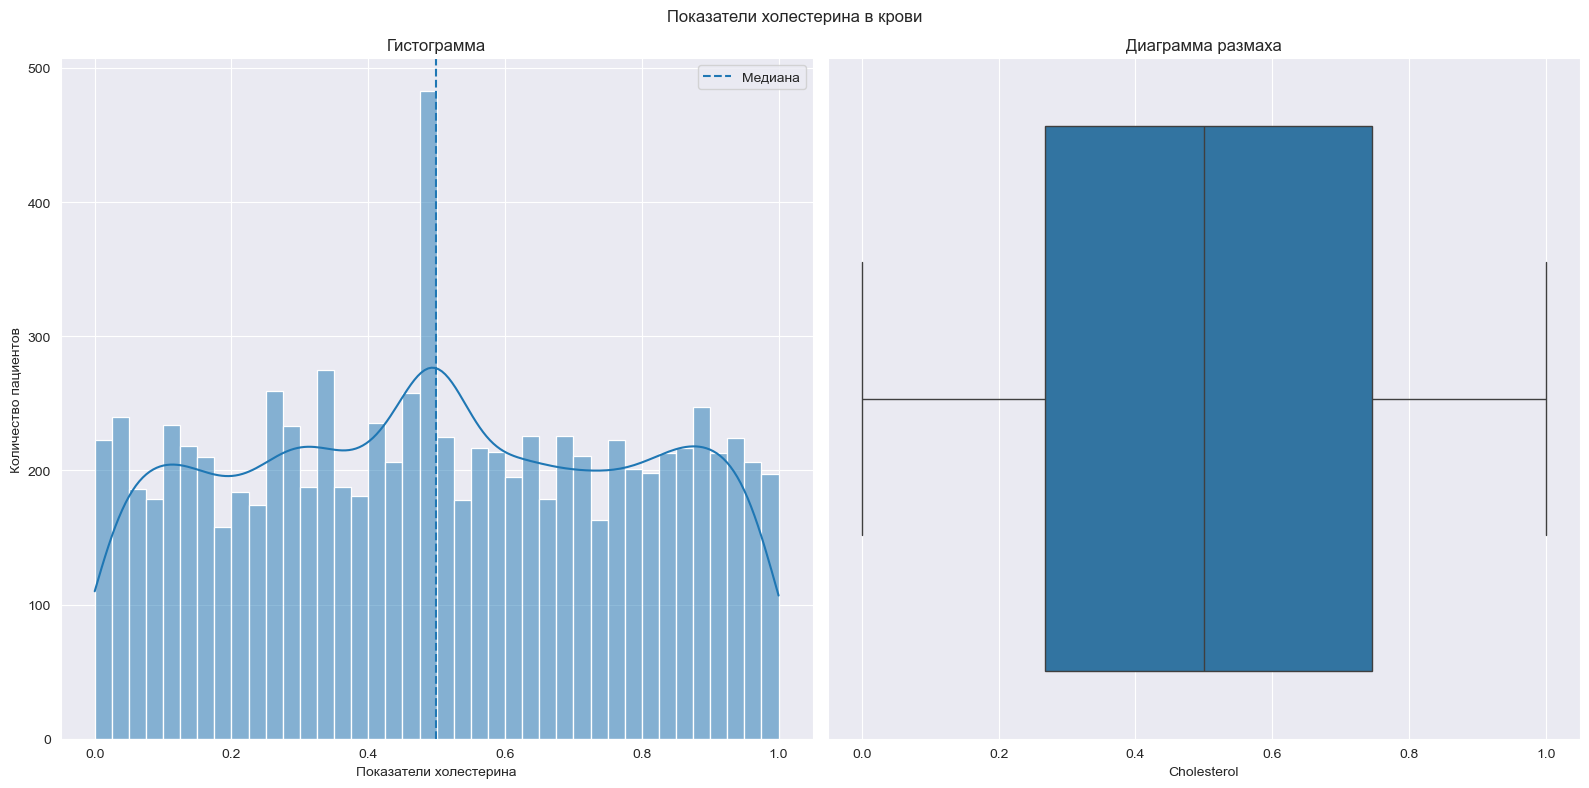

In [146]:
plot_hist_and_box(df_train,
                  column='Cholesterol',
                  axis_label='Показатели холестерина',
                  suptitle='Показатели холестерина в крови'
                 )

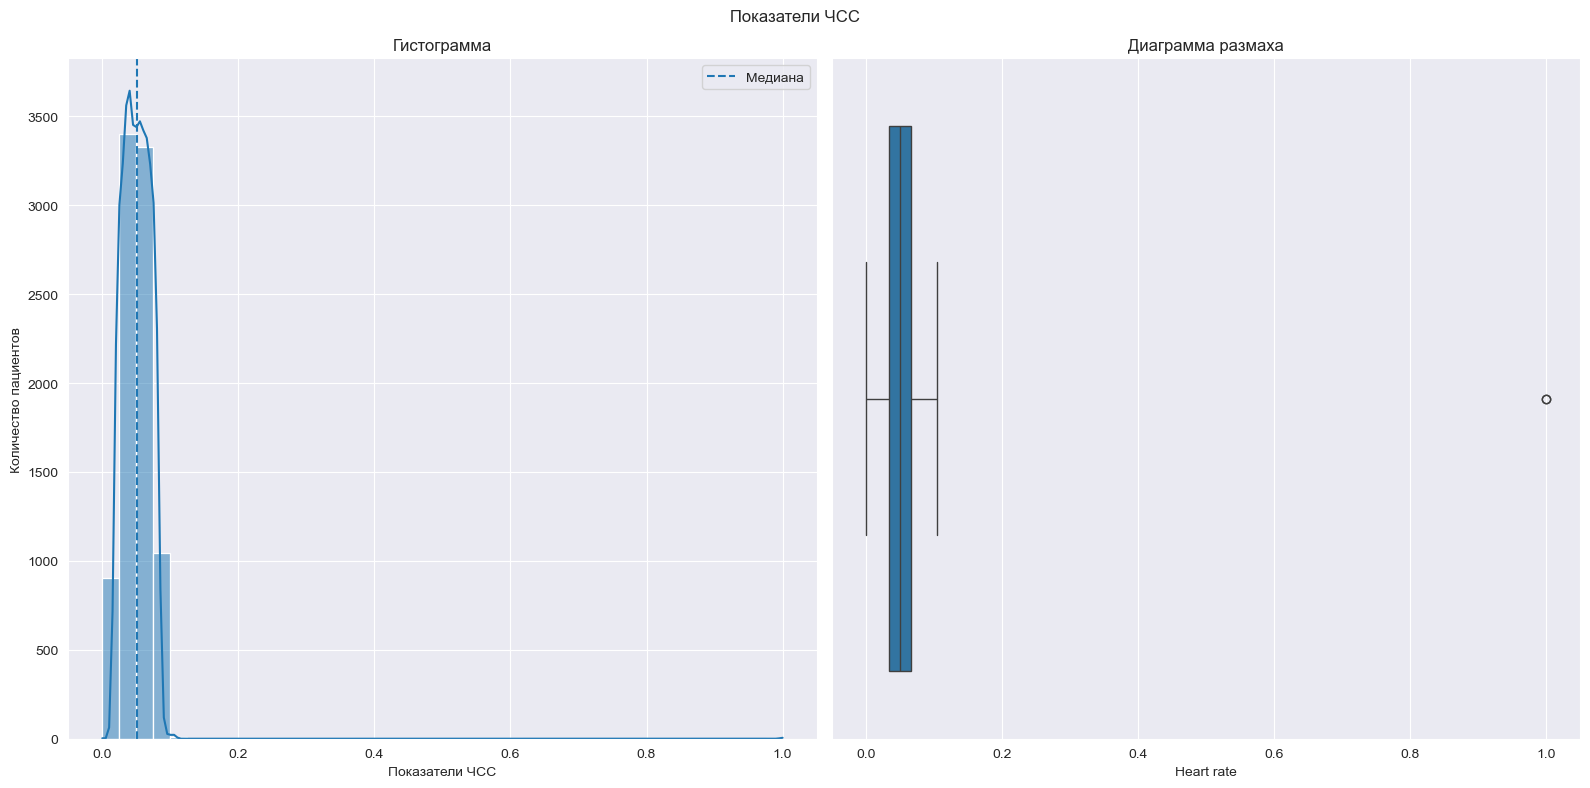

In [147]:
plot_hist_and_box(df_train,
                  column='Heart rate',
                  axis_label='Показатели ЧСС',
                  suptitle='Показатели ЧСС'
                 )

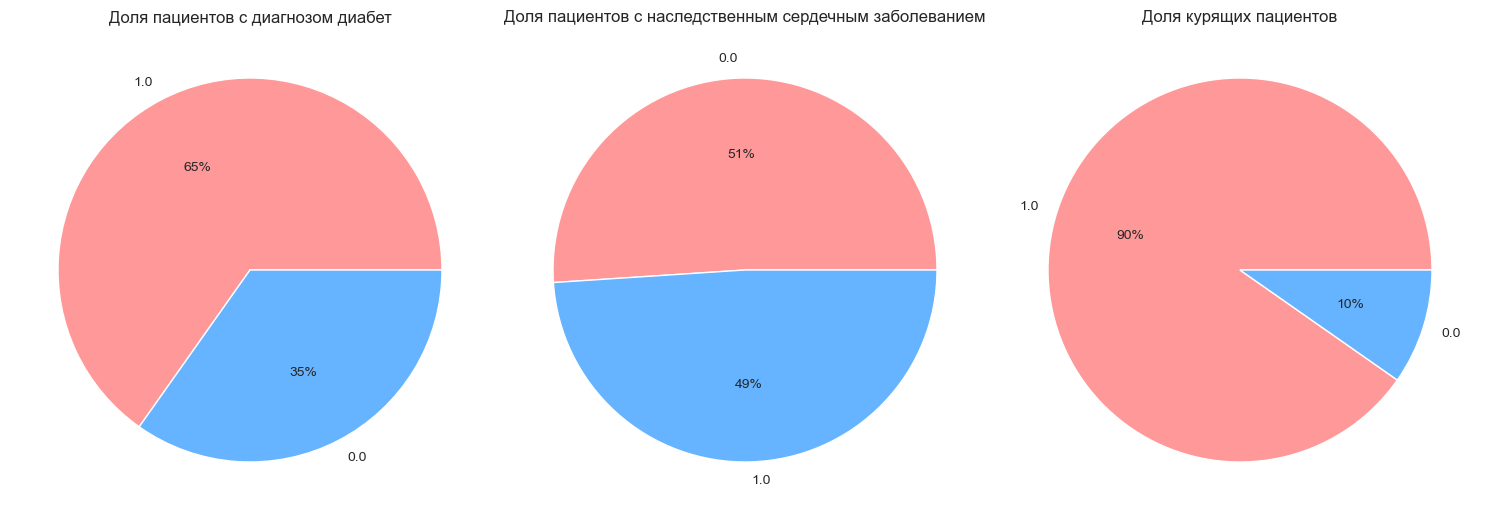

In [148]:
plot_three_pie_charts(df_train,
                      columns=[
                          'Diabetes',
                          'Family History',
                          'Smoking'
                      ],
                      titles=[
                          'Доля пациентов с диагнозом диабет',
                          'Доля пациентов с наследственным сердечным заболеванием',
                          'Доля курящих пациентов'
                      ]
                     )

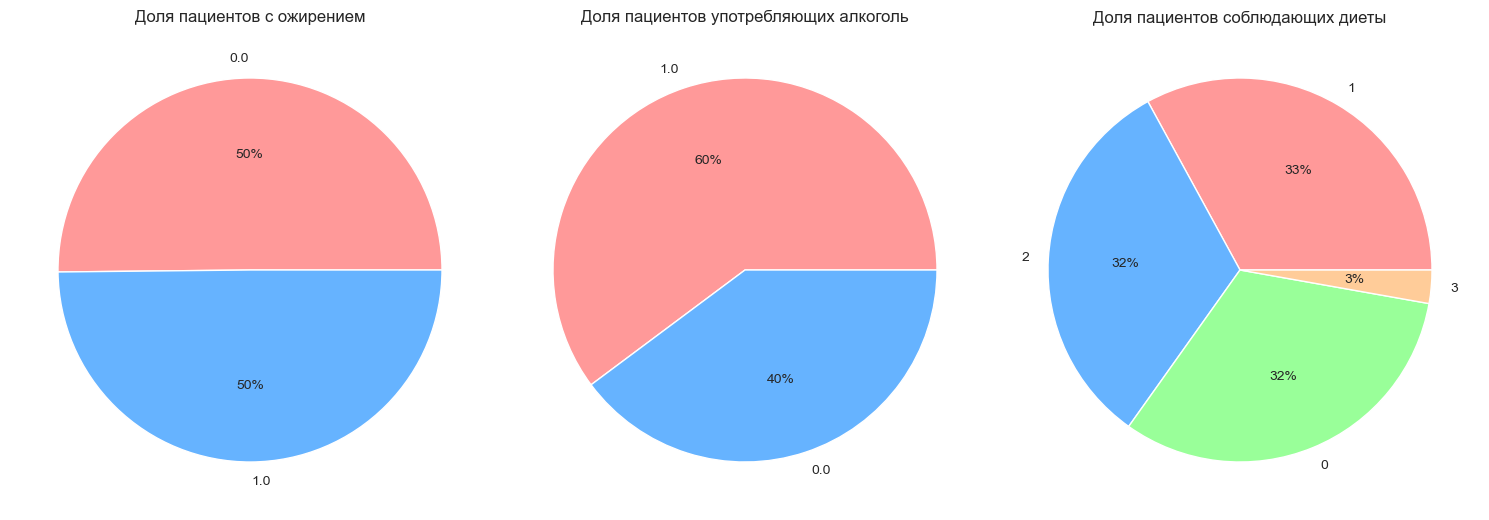

In [149]:
plot_three_pie_charts(df_train,
                      columns=[
                          'Obesity',
                          'Alcohol Consumption',
                          'Diet'
                      ],
                      titles=[
                          'Доля пациентов с ожирением',
                          'Доля пациентов употребляющих алкоголь',
                          'Доля пациентов соблюдающих диеты'
                      ]
                     )

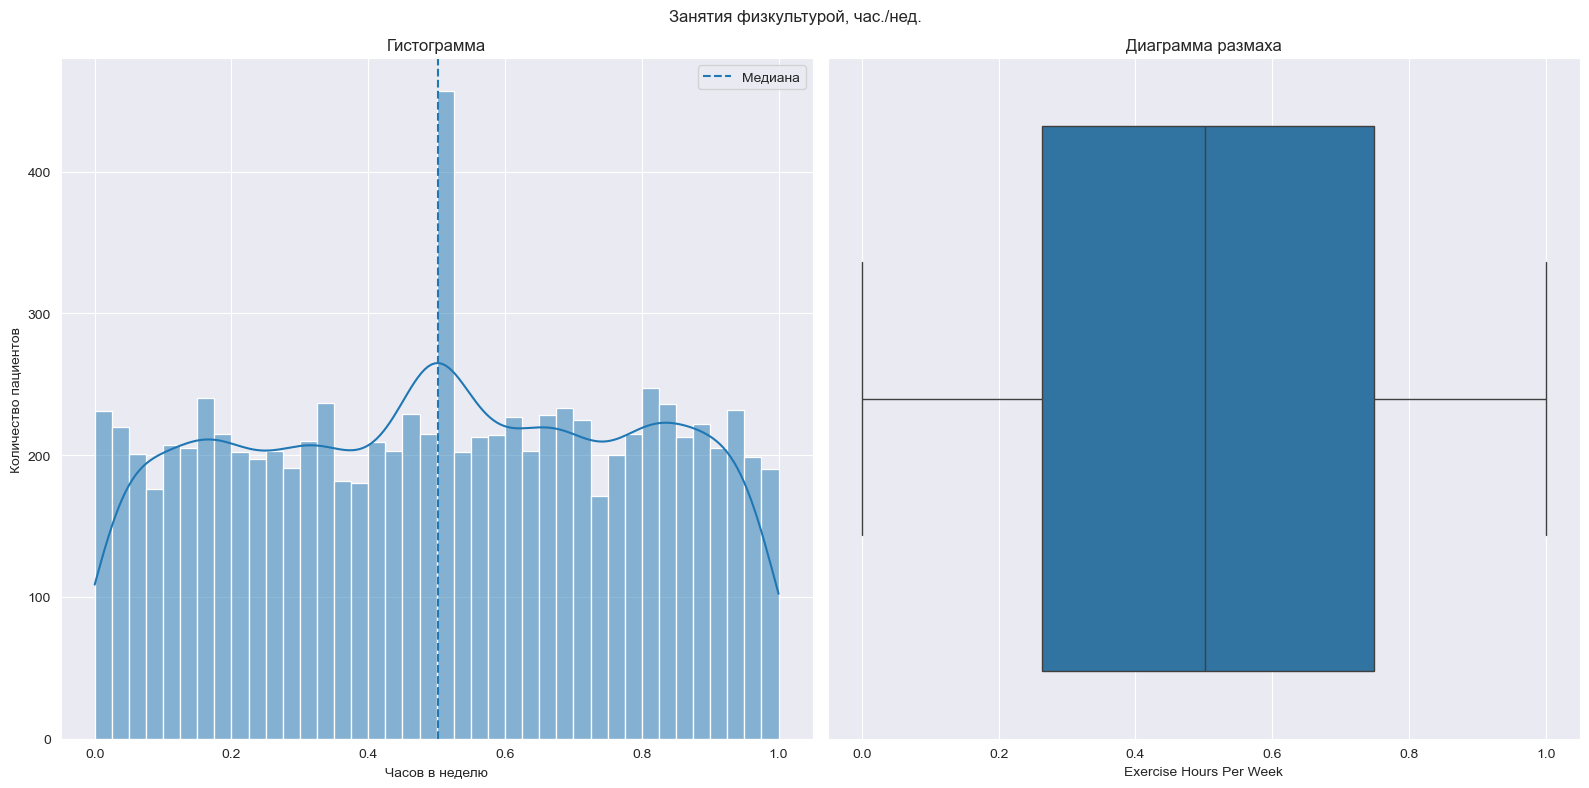

In [150]:
plot_hist_and_box(df_train,
                  column='Exercise Hours Per Week',
                  axis_label='Часов в неделю',
                  suptitle='Занятия физкультурой, час./нед.'
                 )

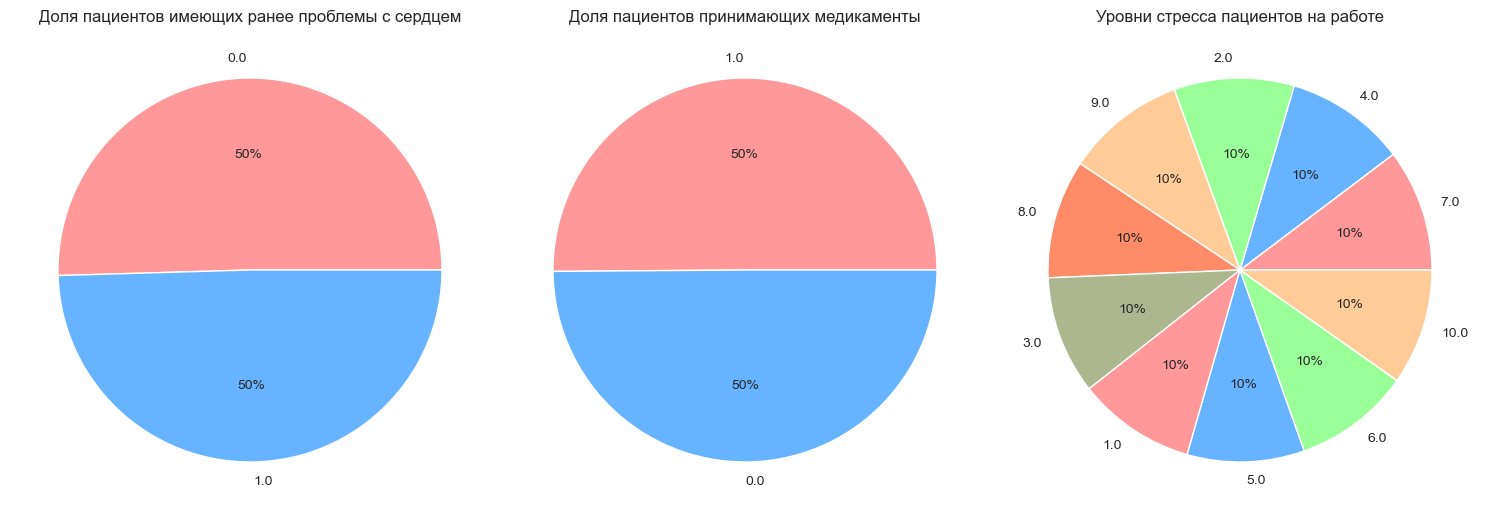

In [151]:
plot_three_pie_charts(df_train,
                      columns=[
                          'Previous Heart Problems',
                          'Medication Use',
                          'Stress Level'
                      ],
                      titles=[
                          'Доля пациентов имеющих ранее проблемы с сердцем',
                          'Доля пациентов принимающих медикаменты',
                          'Уровни стресса пациентов на работе'
                      ]
                     )

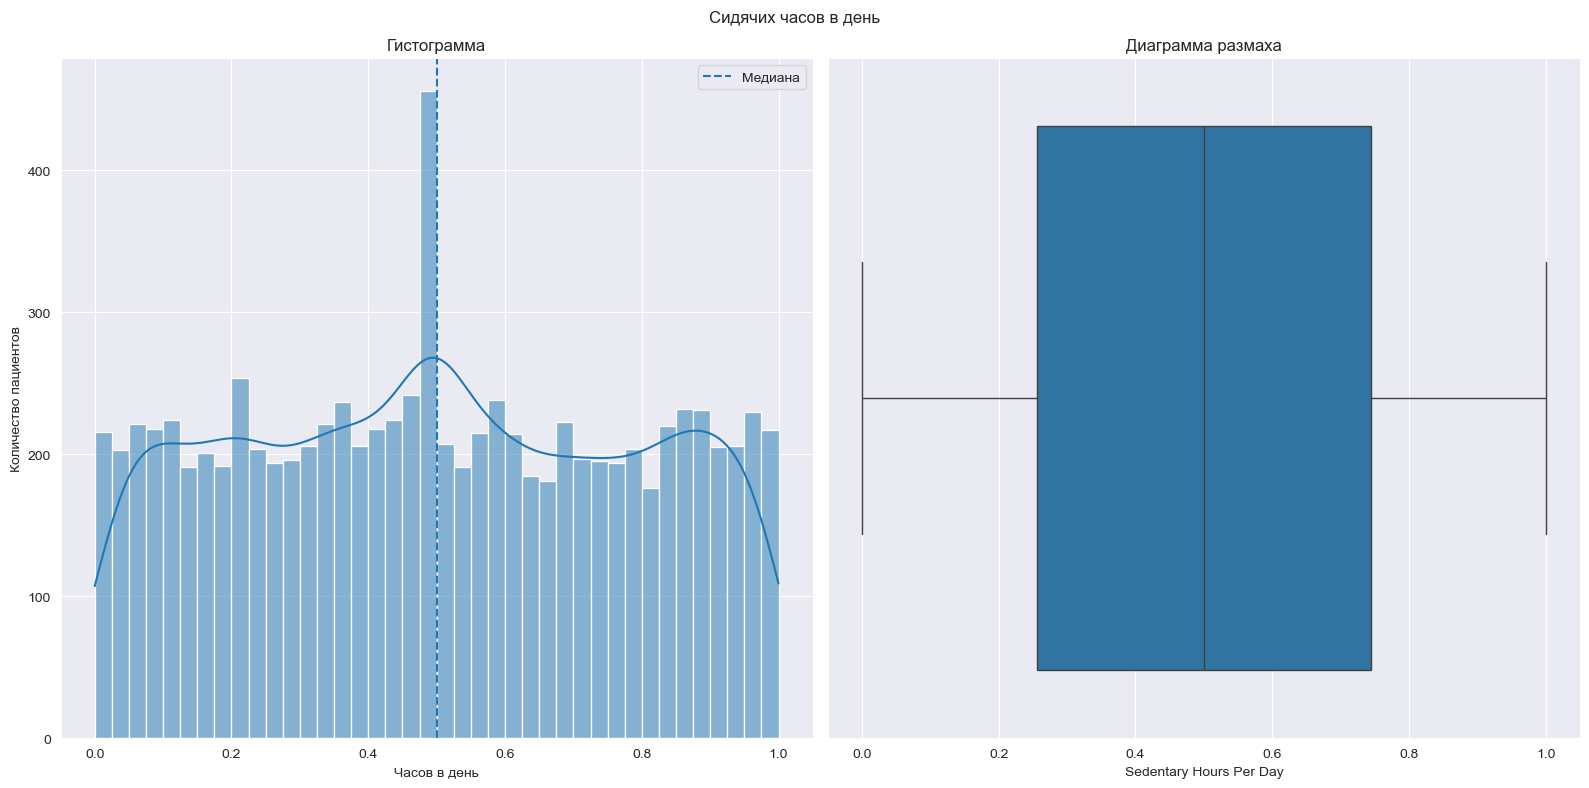

In [152]:
plot_hist_and_box(df_train,
                  column='Sedentary Hours Per Day',
                  axis_label='Часов в день',
                  suptitle='Сидячих часов в день'
                 )

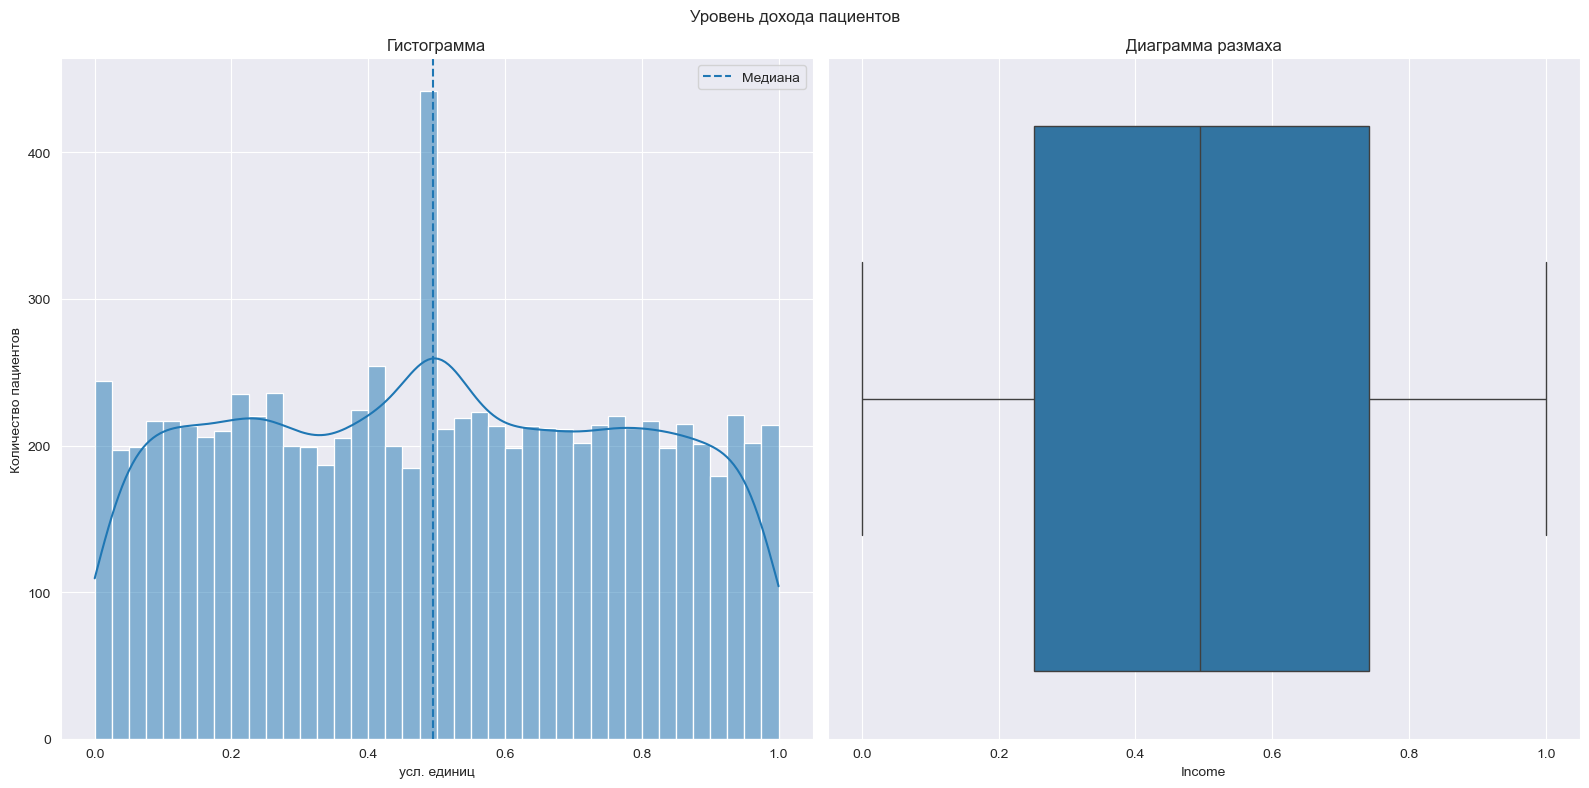

In [153]:
plot_hist_and_box(df_train,
                  column='Income',
                  axis_label='усл. единиц',
                  suptitle='Уровень дохода пациентов'
                 )

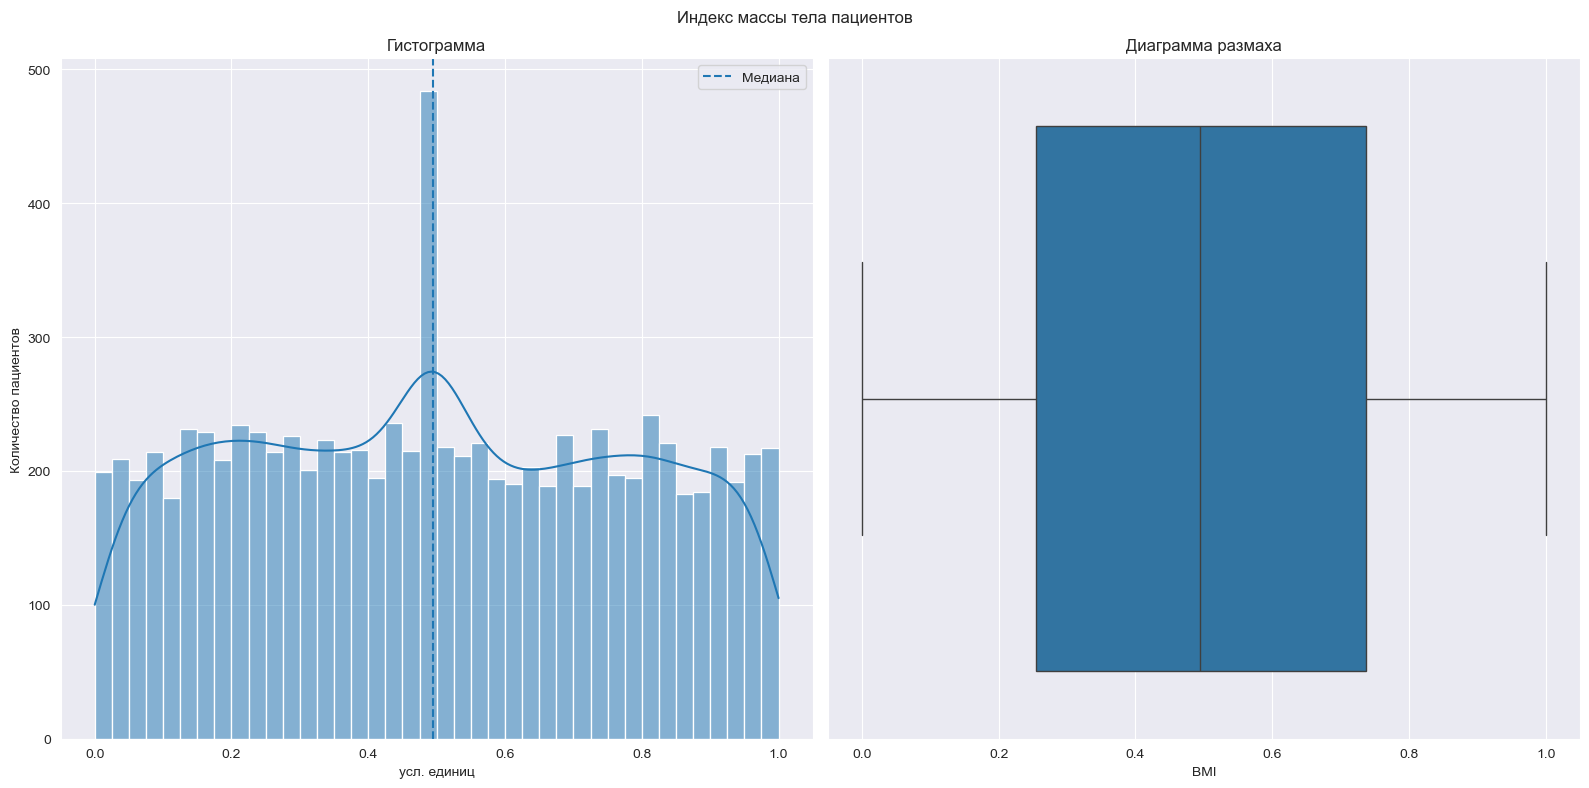

In [154]:
plot_hist_and_box(df_train,
                  column='BMI',
                  axis_label='усл. единиц',
                  suptitle='Индекс массы тела пациентов'
                 )

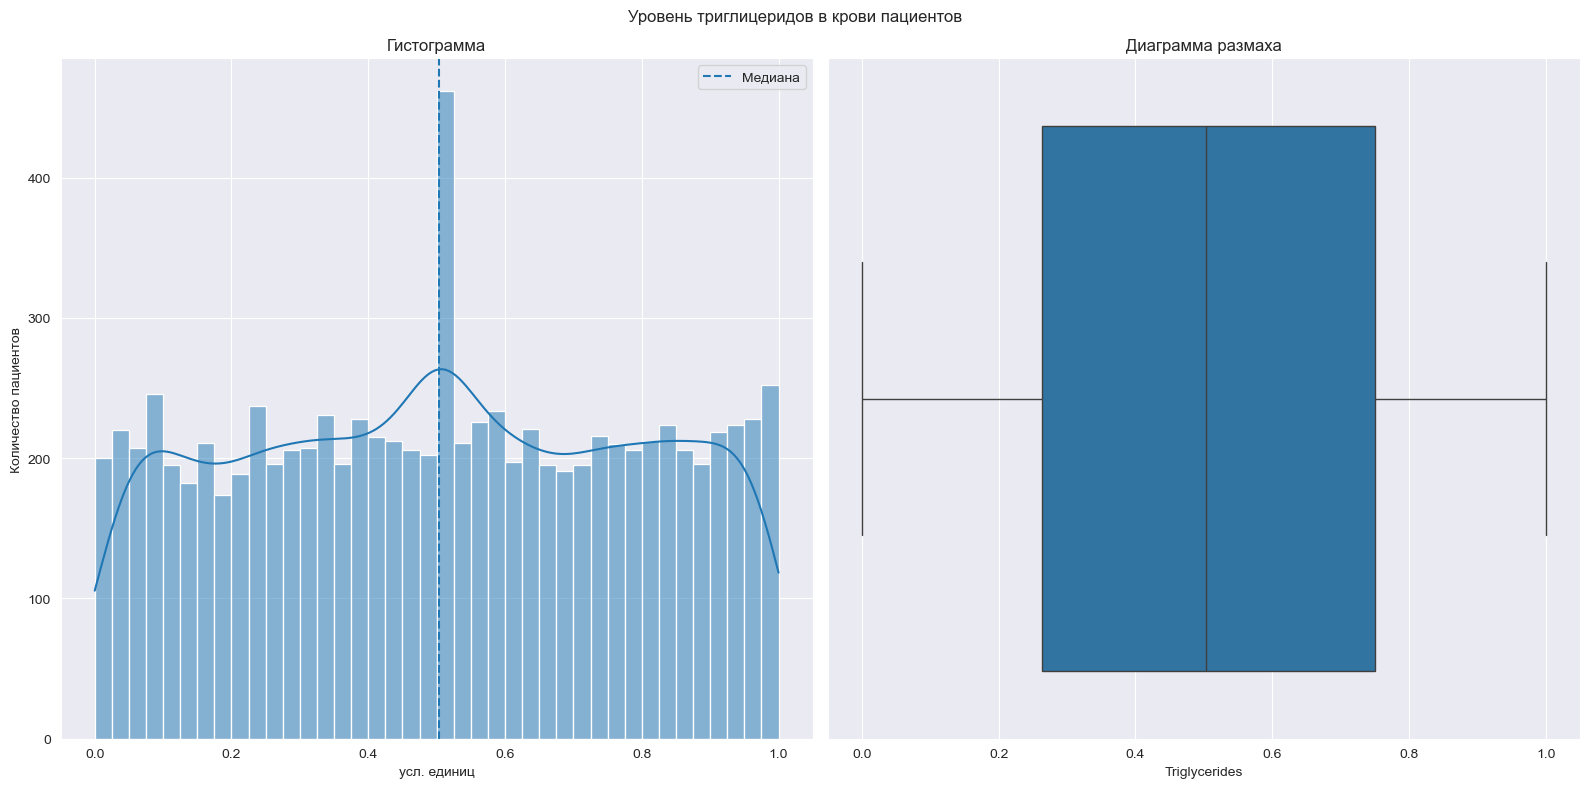

In [155]:
plot_hist_and_box(df_train,
                  column='Triglycerides',
                  axis_label='усл. единиц',
                  suptitle='Уровень триглицеридов в крови пациентов'
                 )

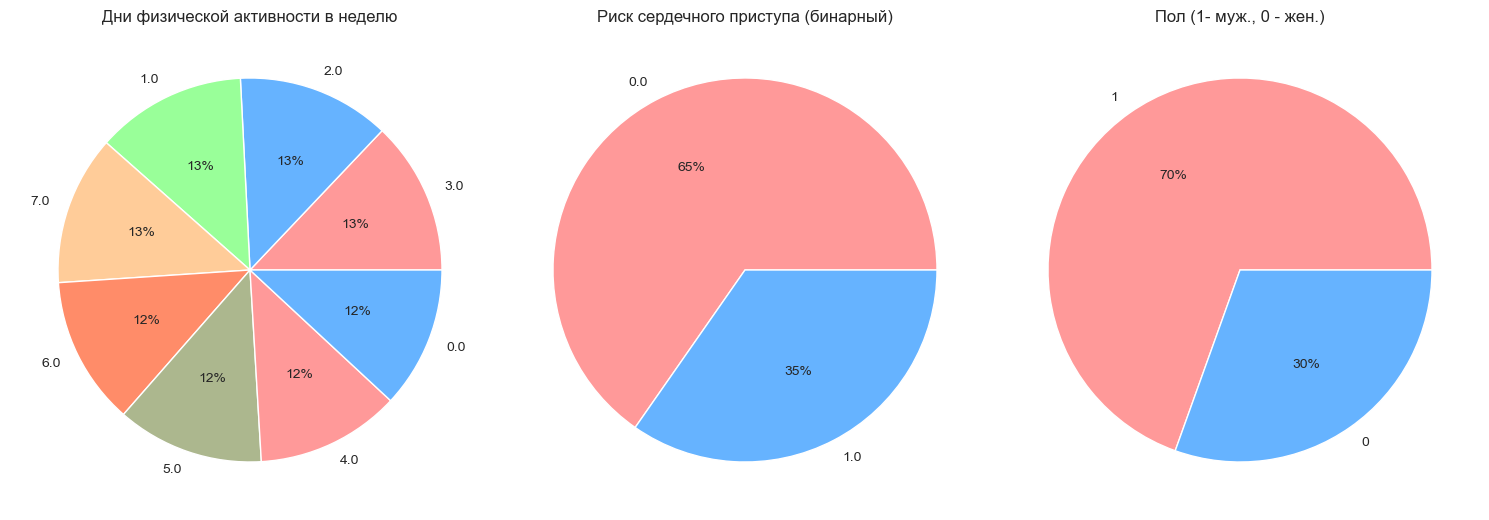

In [156]:
plot_three_pie_charts(df_train,
                      columns=[
                          'Physical Activity Days Per Week',
                          'Heart Attack Risk (Binary)',
                          'Gender'
                      ],
                      titles=[
                          'Дни физической активности в неделю',
                          'Риск сердечного приступа (бинарный)',
                          'Пол (1- муж., 0 - жен.)'
                      ]
                     )

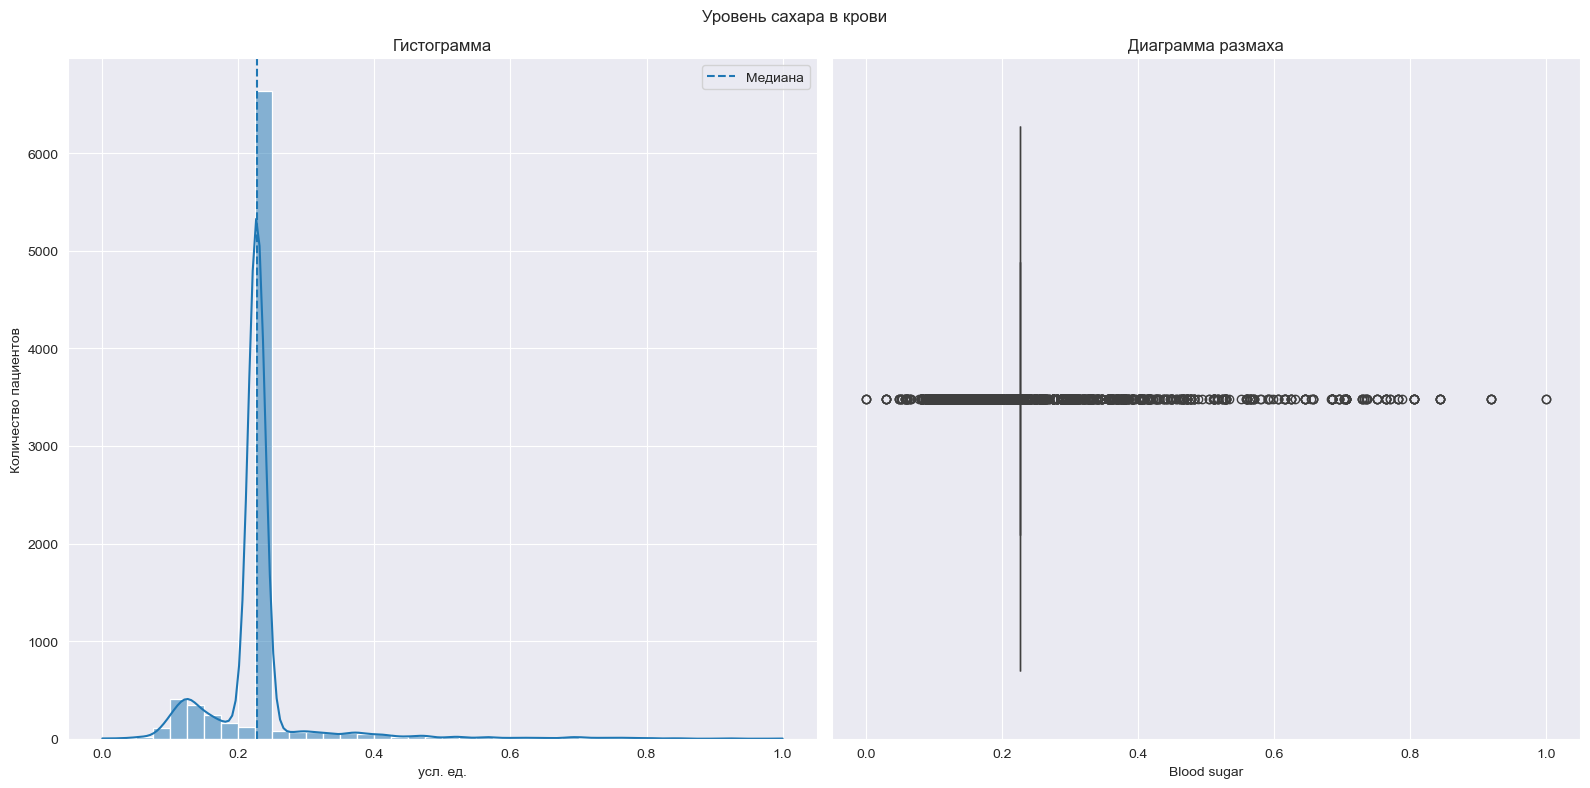

In [157]:
plot_hist_and_box(df_train,
                  column='Blood sugar',
                  axis_label='усл. ед.',
                  suptitle='Уровень сахара в крови'
                 )

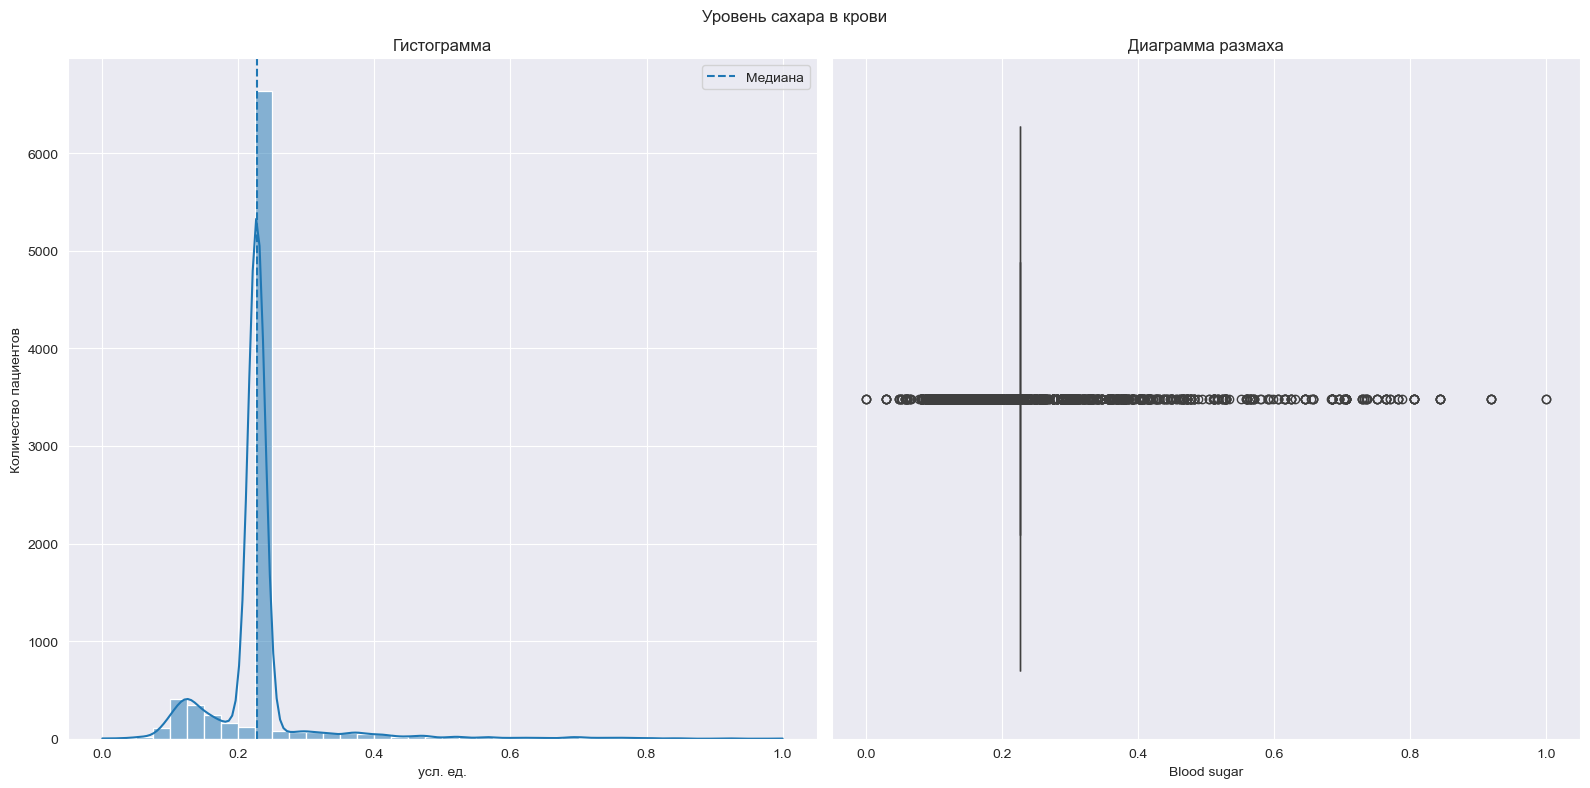

In [158]:
plot_hist_and_box(df_train,
                  column='Blood sugar',
                  axis_label='усл. ед.',
                  suptitle='Уровень сахара в крови'
                 )

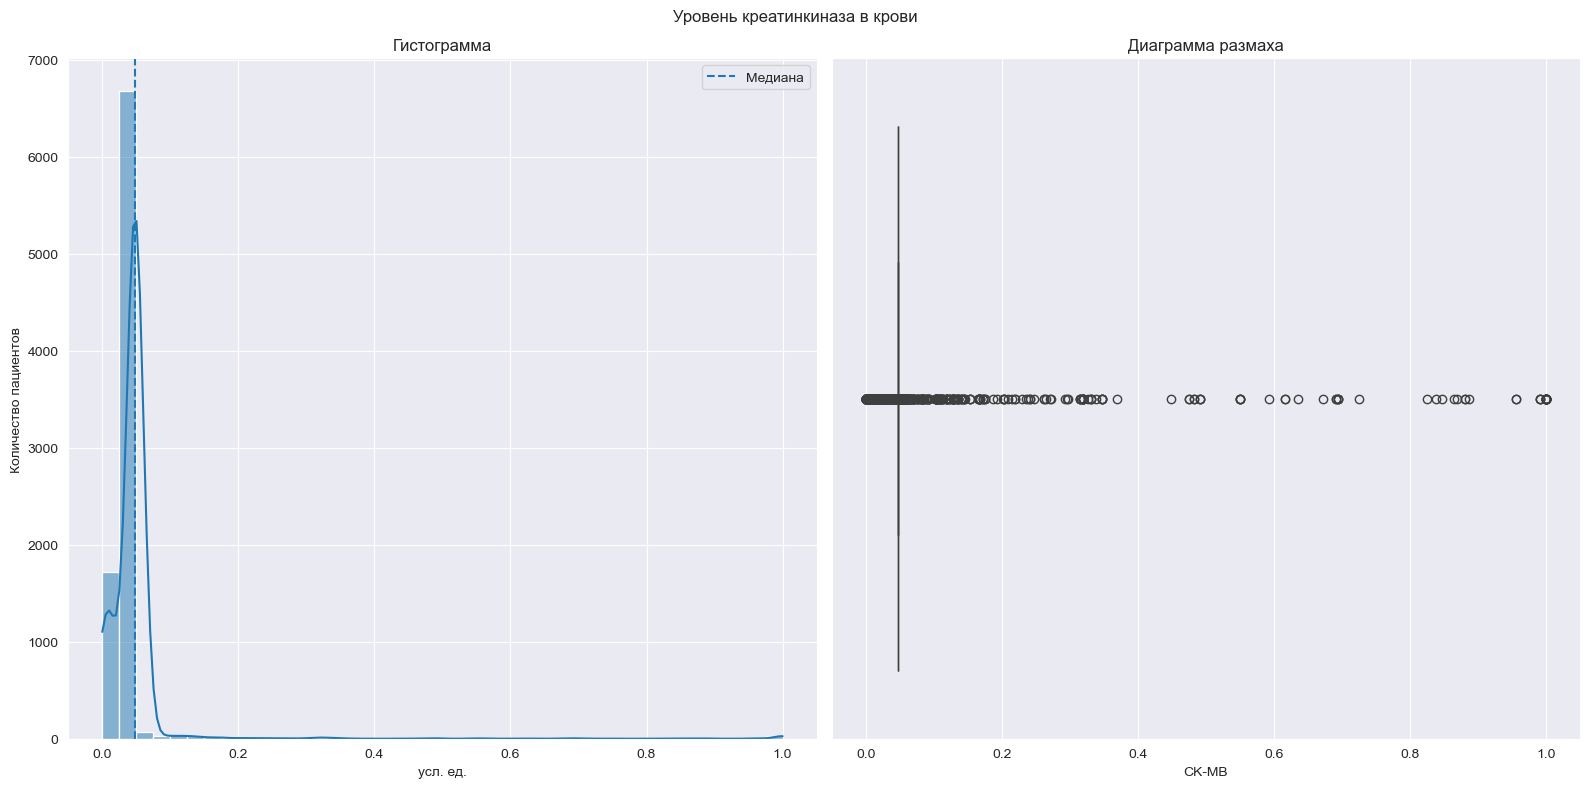

In [159]:
plot_hist_and_box(df_train,
                  column='CK-MB',
                  axis_label='усл. ед.',
                  suptitle='Уровень креатинкиназа в крови'
                 )

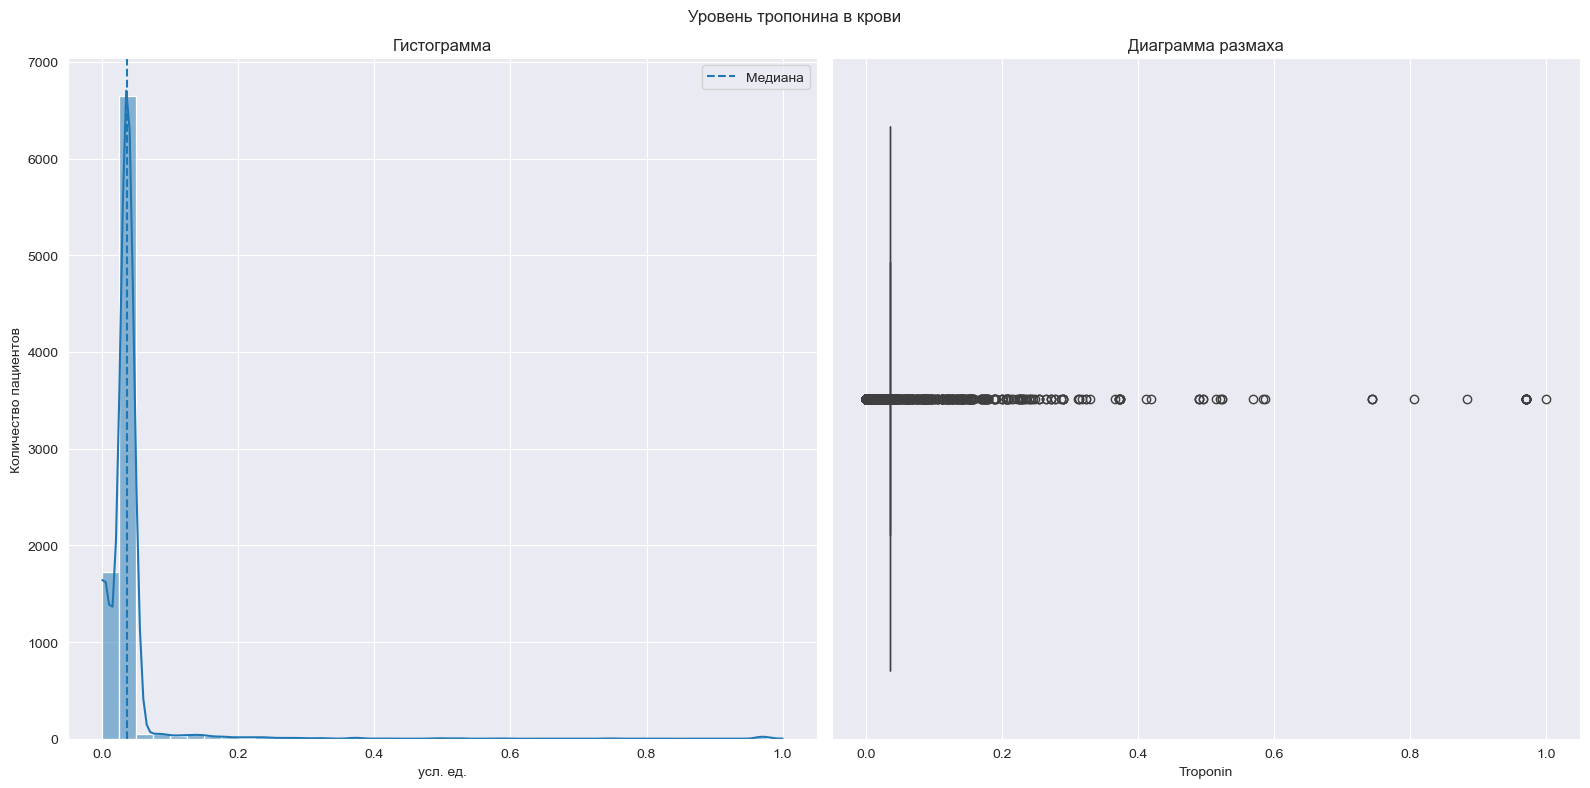

In [160]:
plot_hist_and_box(df_train,
                  column='Troponin',
                  axis_label='усл. ед.',
                  suptitle='Уровень тропонина в крови'
                 )

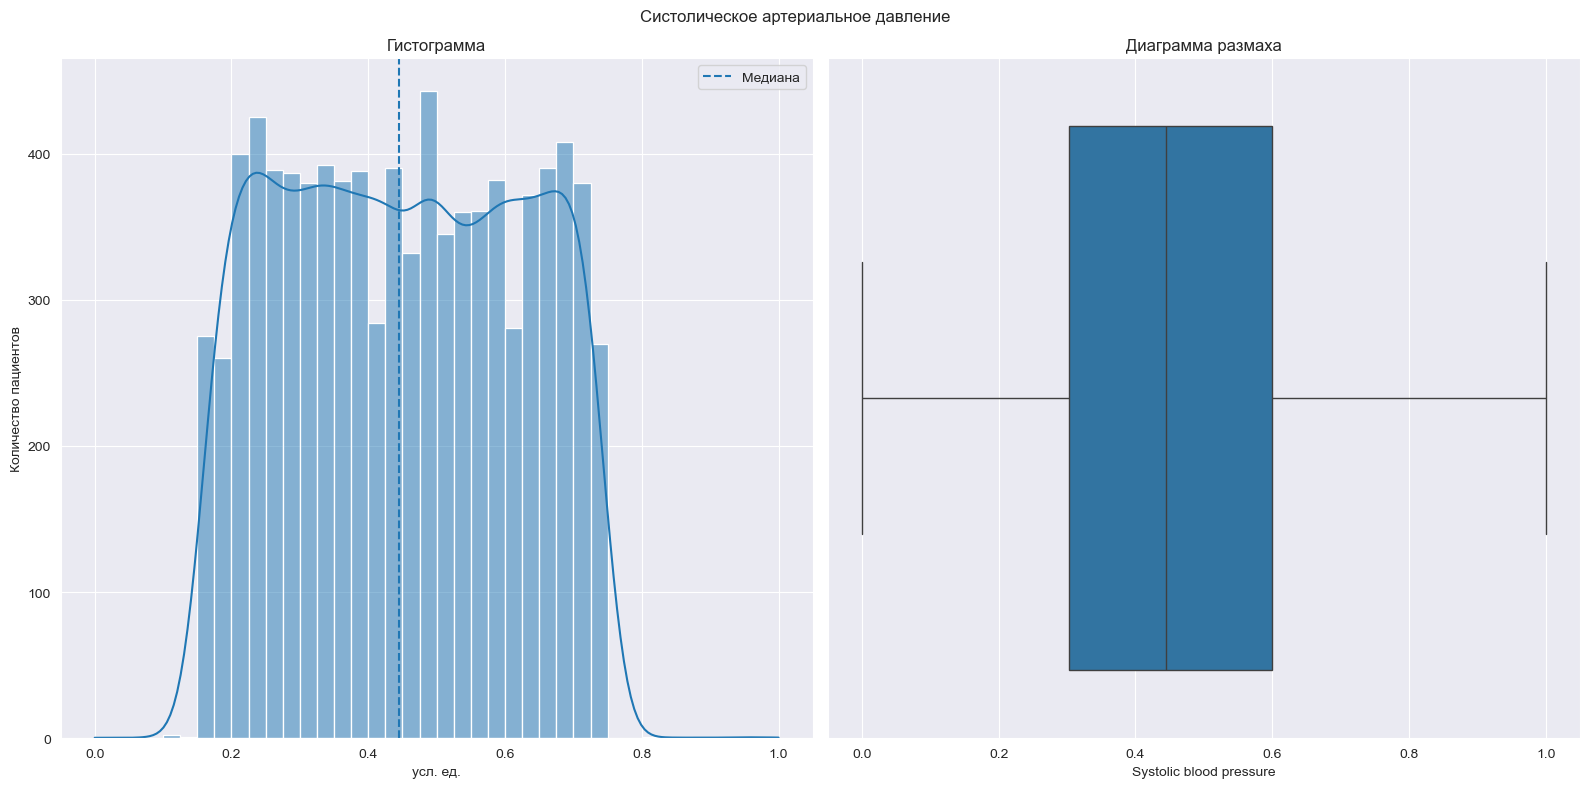

In [161]:
plot_hist_and_box(df_train,
                  column='Systolic blood pressure',
                  axis_label='усл. ед.',
                  suptitle='Систолическое артериальное давление'
                 )

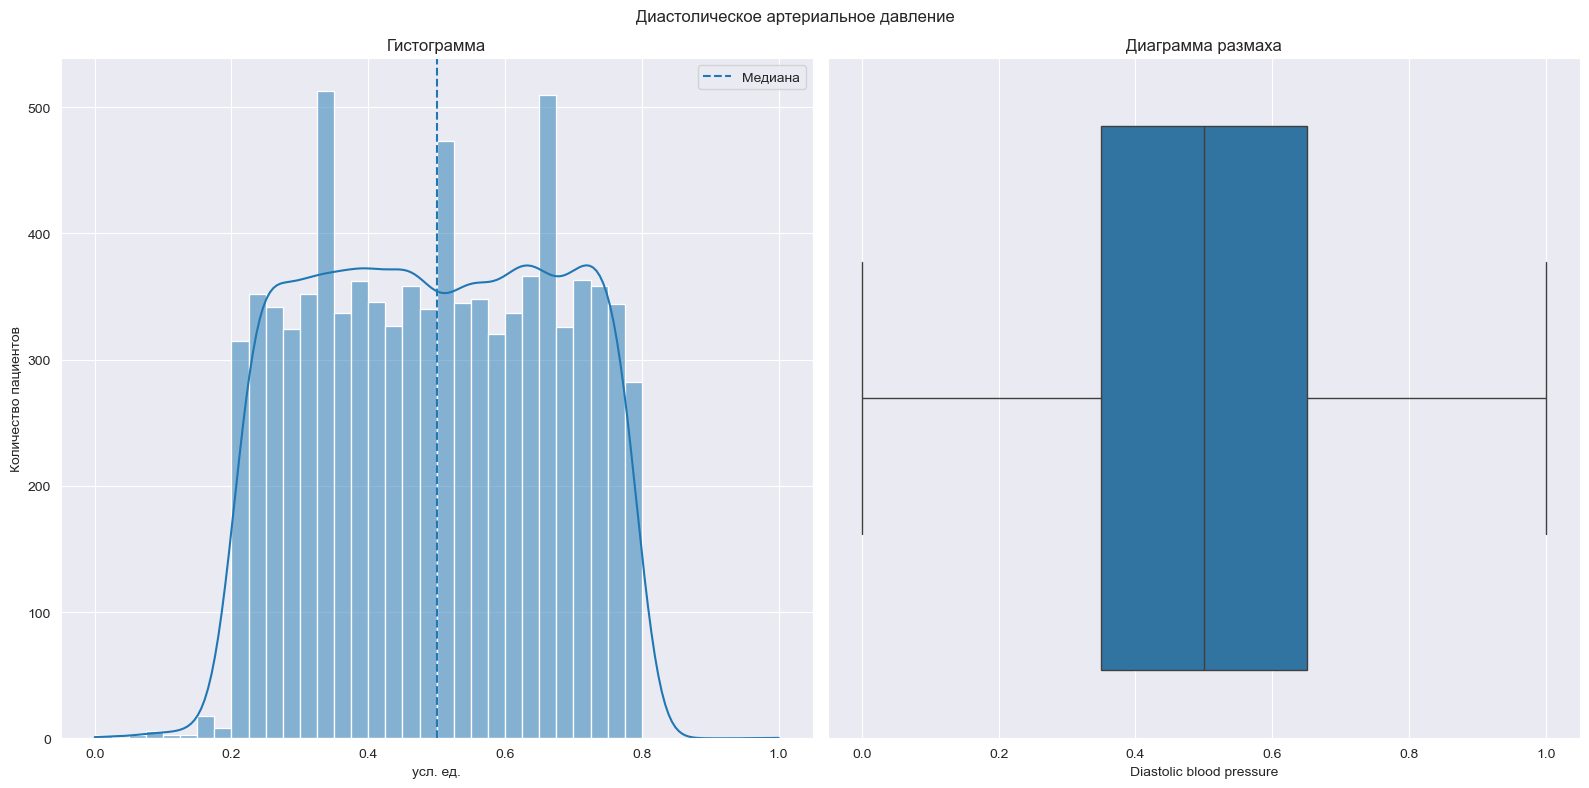

In [162]:
plot_hist_and_box(df_train,
                  column='Diastolic blood pressure',
                  axis_label='усл. ед.',
                  suptitle='Диастолическое артериальное давление'
                 )

## 4. Корреляционный анализ

<div style="background-color:lavender; color:#black; text-align:left; padding:2%">
<font size="4", color= "black">Матрица корреляции количественных признаков:</font>

In [163]:
# Заполняем числовые пропуски медианой
df_train_filled = df_train.fillna(df_train.median(numeric_only=True))
# Строим матрицу корреляции
df_train_filled.phik_matrix().style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure', 'id']


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
Age,1.000000,0.020162,0.000000,0.006214,0.000000,0.633736,0.021942,0.046839,0.074474,0.146152,0.016216,0.000000,0.084895,0.053881,0.026848,0.000000,0.078348,0.040701,0.119201,0.041341,0.362167,0.182926,0.120650,0.027679,0.341784,0.079151,0.144213
Cholesterol,0.020162,1.000000,0.092227,0.047874,0.076535,0.035484,0.078460,0.122072,0.215699,0.394187,0.069964,0.099388,0.216286,0.203118,0.193734,0.210630,0.204660,0.135852,0.325957,0.057544,0.089148,0.061413,0.028913,0.034663,0.084171,0.136848,0.229825
Heart rate,0.000000,0.092227,1.000000,0.012305,0.018279,0.000000,0.018673,0.014376,0.098293,0.155665,0.018539,0.018694,0.098963,0.094807,0.098627,0.095438,0.096140,0.082424,0.224860,0.012679,0.079090,0.158237,0.000000,0.016486,0.044381,0.063070,0.114863
Diabetes,0.006214,0.047874,0.012305,1.000000,0.058723,0.000000,0.000000,0.026723,0.068395,0.181134,0.002529,0.009772,0.039466,0.089457,0.065124,0.057324,0.076814,0.084093,0.165738,0.000000,0.016182,0.000000,0.018382,0.000000,0.040225,0.046004,0.081047
Family History,0.000000,0.076535,0.018279,0.058723,1.000000,0.000000,0.014276,0.000000,0.100772,0.241902,0.038012,0.029239,0.104817,0.078351,0.129292,0.105213,0.078878,0.058631,0.216525,0.031260,0.075161,0.000000,0.000000,0.006900,0.025842,0.069076,0.105219
Smoking,0.633736,0.035484,0.000000,0.000000,0.000000,1.000000,0.000000,0.022701,0.017213,0.080393,0.006706,0.000000,0.000000,0.029073,0.000000,0.015947,0.059882,0.036312,0.072868,0.006936,0.128515,0.025469,0.035542,0.692696,0.000000,0.005502,0.055837
Obesity,0.021942,0.078460,0.018673,0.000000,0.014276,0.000000,1.000000,0.058464,0.113952,0.246241,0.051429,0.048327,0.104677,0.091495,0.100355,0.096654,0.082790,0.076657,0.216662,0.000000,0.044098,0.015493,0.010907,0.000000,0.038415,0.067389,0.096044
Alcohol Consumption,0.046839,0.122072,0.014376,0.026723,0.000000,0.022701,0.058464,1.000000,0.072921,0.201974,0.028534,0.045543,0.069659,0.118593,0.087005,0.063825,0.101586,0.067074,0.176613,0.045199,0.049059,0.000000,0.011038,0.004279,0.000000,0.056306,0.102735
Exercise Hours Per Week,0.074474,0.215699,0.098293,0.068395,0.100772,0.017213,0.113952,0.072921,1.000000,0.413224,0.117464,0.078751,0.215405,0.213589,0.232896,0.209044,0.210127,0.139459,0.340633,0.062494,0.120901,0.024905,0.000000,0.037220,0.045203,0.144910,0.248872
Diet,0.146152,0.394187,0.155665,0.181134,0.241902,0.080393,0.246241,0.201974,0.413224,1.000000,0.247011,0.247102,0.414743,0.402445,0.413922,0.404518,0.407874,0.478921,0.886625,0.186541,0.260180,0.124155,0.081056,0.015207,0.176467,0.377287,0.462294


## 5. Обучение моделей


In [164]:
# Разделение на признаки и целевую переменную
X = df_train.drop(['Heart Attack Risk (Binary)'], axis=1)
y = df_train['Heart Attack Risk (Binary)']

In [165]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=y,
    test_size=0.2
)

In [166]:
print("Распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Распределение классов в обучающей выборке:
Heart Attack Risk (Binary)
0.0    0.653138
1.0    0.346862
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Heart Attack Risk (Binary)
0.0    0.65285
1.0    0.34715
Name: proportion, dtype: float64


In [167]:
numeric_features = ['Age', 'Gender', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week',
                   'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
                   'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure',
                   'Diastolic blood pressure', 'Diabetes', 'Family History', 'Smoking',
                   'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems',
                   'Medication Use', 'Stress Level', 'Physical Activity Days Per Week',
                   'Sleep Hours Per Day']

# Создаем только числовой трансформер
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])


In [168]:
# Словарь с моделями
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state=42),
    'CatBoost': CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        verbose=False,
        random_state=42
    )
}
results = {}

In [169]:
# Обучение и оценка каждой модели
for name, model in models.items():
    print(f"\nОбучение модели {name}...")

    # Создаем пайплайн с предобработкой и моделью
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Кросс-валидация
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

    # Обучение на всей обучающей выборке
    pipeline.fit(X_train, y_train)

    # Предсказания на тестовой выборке
    y_pred = pipeline.predict(X_test)

    # Сохранение результатов
    results[name] = {
    'model': pipeline,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'test_accuracy': accuracy_score(y_test, y_pred),
    'classification_report': classification_report(y_test, y_pred, zero_division=1)
    }

    # Сохранение модели
    joblib.dump(pipeline, f'models/{name}_pipeline.joblib')


Обучение модели RandomForest...

Обучение модели GradientBoosting...

Обучение модели SVC...

Обучение модели KNN...

Обучение модели LogisticRegression...

Обучение модели CatBoost...


### 6. Анализ результатов


In [170]:
# Создаем DataFrame для сравнения моделей
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'CV Score': [result['cv_mean'] for result in results.values()],
    'CV Std': [result['cv_std']*2 for result in results.values()],
    'Test Accuracy': [result['test_accuracy'] for result in results.values()]
})

# Форматируем числовые значения
comparison_df['CV Score'] = comparison_df['CV Score'].map('{:.3f}'.format)
comparison_df['CV Std'] = comparison_df['CV Std'].map('{:.3f}'.format)
comparison_df['Test Accuracy'] = comparison_df['Test Accuracy'].map('{:.3f}'.format)

# Добавляем CV Score с доверительным интервалом
comparison_df['CV Score (±)'] = comparison_df.apply(
    lambda x: f"{x['CV Score']} (± {x['CV Std']})",
    axis=1
)

# Выбираем и сортируем нужные колонки
final_comparison = comparison_df[['Model', 'CV Score (±)', 'Test Accuracy']].sort_values(
    'Test Accuracy',
    ascending=False
)

# Отображаем результаты
display(final_comparison.style.set_properties(**{
    'text-align': 'left',
    'padding': '5px'
}).hide(axis='index'))

# Создаем DataFrame для детальных метрик по классам
detailed_metrics = []

for name, result in results.items():
    # Парсим classification report
    report_lines = result['classification_report'].split('\n')
    metrics = {}
    metrics['Model'] = name

    # Извлекаем метрики для каждого класса
    for line in report_lines:
        line = line.strip()
        if line and line.split()[0] in ['0.0', '1.0']:  # Ищем строки с метриками классов
            parts = line.split()
            class_label = parts[0].split('.')[0]  # Убираем десятичную точку
            try:
                precision = float(parts[1])
                recall = float(parts[2])
                f1_score = float(parts[3])

                metrics[f'Class {class_label} Precision'] = f'{precision:.3f}'
                metrics[f'Class {class_label} Recall'] = f'{recall:.3f}'
                metrics[f'Class {class_label} F1'] = f'{f1_score:.3f}'
            except (ValueError, IndexError):
                continue

    detailed_metrics.append(metrics)

# Создаем DataFrame с детальными метриками
detailed_df = pd.DataFrame(detailed_metrics)

# Определяем порядок колонок
columns_order = ['Model']
for i in ['0', '1']:
    for metric in ['Precision', 'Recall', 'F1']:
        col = f'Class {i} {metric}'
        if col in detailed_df.columns:
            columns_order.append(col)

# Сортируем по F1-мере класса 1
if 'Class 1 F1' in detailed_df.columns:
    detailed_df = detailed_df.sort_values('Class 1 F1', ascending=False)

# Отображаем детальные метрики
display(detailed_df[columns_order].style.set_properties(**{
    'text-align': 'left',
    'padding': '5px'
}).hide(axis='index'))

Model,CV Score (±),Test Accuracy
RandomForest,0.666 (± 0.010),0.670
GradientBoosting,0.653 (± 0.004),0.657
SVC,0.653 (± 0.001),0.655
LogisticRegression,0.653 (± 0.001),0.653
KNN,0.589 (± 0.007),0.586
CatBoost,0.612 (± 0.013),0.585


Model,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 1 Precision,Class 1 Recall,Class 1 F1
CatBoost,0.670,0.710,0.690,0.390,0.350,0.370
KNN,0.650,0.770,0.710,0.350,0.230,0.280
RandomForest,0.670,0.980,0.790,0.690,0.090,0.160
GradientBoosting,0.660,0.990,0.790,0.610,0.030,0.060
SVC,0.650,1.000,0.790,1.000,0.000,0.010
LogisticRegression,0.650,1.000,0.790,1.000,0.000,0.000


Анализируя предоставленные результаты:
1. RandomForest показывает лучшие общие результаты:
    - Наивысший accuracy (0.670)
    - Лучший F1-score для положительного класса (0.16)
    - Хороший баланс precision/recall
    - Стабильная cross-validation (0.666 ± 0.010)

2. CatBoost показывает более сбалансированные результаты для обоих классов, но общая точность ниже:
    - Лучший баланс между precision и recall для класса 1
    - Более высокий F1-score для положительного класса (0.37)
    - Но общая точность ниже (0.585)

3. Остальные модели показывают худшие результаты или сильный дисбаланс в предсказаниях.

В данном случае, нам важнее всего выявление положительных случаев (риск сердечного приступа), поэтому лучше использовать CatBoost, так как он показывает более сбалансированные результаты для обоих классов. Если же важнее была бы общая точность, то лучше использовать RandomForest.


### 7. Создание предсказаний для тестовой выборки


In [171]:
# Находим модель с лучшим F1-score для класса 1
best_model_name = max(results.keys(),
                     key=lambda k: get_class_1_f1(results[k]['classification_report']))

best_model = results[best_model_name]['model']

print(f"Выбрана лучшая модель: {best_model_name}")

# Создаем предсказания для тестового набора данных
predictions = best_model.predict(df_test)

# Создаем DataFrame с предсказаниями и ID
predictions_df = pd.DataFrame({
    'id': df_test.index,
    'prediction': predictions.astype(int)  # убедимся, что предсказания целочисленные
})

# Сохраняем предсказания
predictions_df.to_csv('data/predictions.csv', index=False)
print(f"\nПредсказания сохранены в файл: data/predictions.csv")

Выбрана лучшая модель: CatBoost

Предсказания сохранены в файл: data/predictions.csv
